# Modeling

- Overview Here

## Model Evaluation

- TBD

In [1]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd

# Set style
plt.style.use('seaborn')

In [2]:
# Import util file

from util import dickey_fuller, process_neighborhood, report_metrics, plot_results

In [208]:
# Modeling

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsa

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima.arima import nsdiffs
from pmdarima.arima import CHTest
from pmdarima.arima.stationarity import ADFTest

from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [4]:
# Import clean dataset

df = pd.read_csv('./clean_data/final_clean_ridership.csv', low_memory=False)

In [5]:
# Convert starttime to date and set as index

df['starttime'] = pd.to_datetime(df['starttime'])

df.set_index('starttime', inplace=True)

In [6]:
df.head()

,station_id,lat,long,ride_count,year,neighborhood,borough
starttime,,,,,,,
2013-06-01,72,40.767272,-73.993929,40,2013,Clinton,Manhattan
2013-06-01,79,40.719116,-74.006667,61,2013,SoHo-TriBeCa-Civic Center-Little Italy,Manhattan
2013-06-01,82,40.711174,-74.000165,6,2013,Chinatown,Manhattan
2013-06-01,83,40.683826,-73.976323,32,2013,Fort Greene,Brooklyn
2013-06-01,116,40.741776,-74.001497,53,2013,Hudson Yards-Chelsea-Flatiron-Union Square,Manhattan


In [7]:
# Create the daily file

daily_ridership = df[['ride_count']].resample('1D').sum()

# Filter for only data prior to 5/1/2021 (logic for this is in the EDA notebook)
# Note: this is commented out as I've found a better solution. Want to keep code in case I revert.
# daily_ridership = daily_ridership[daily_ridership.index < '2021-06-01']

# Backfill dates with 0 rides (logic for this change in EDA notebook)
daily_ridership['ride_count'] = daily_ridership['ride_count'].replace(to_replace=0, method='bfill')

## Naive Baseline

- Take average of the train data to predict the test
- Fit a simple linear regression
- The testing data will be from June 1st 2020 to June 1st 2021. This is to ensure that when I bring exogenous variables in down the line that the training data has some period from COVID to train on.

### Average of Train Period

In [8]:
# Inserting a time period track for our naive models

daily_ridership.insert(0, 't', range(len(daily_ridership)))

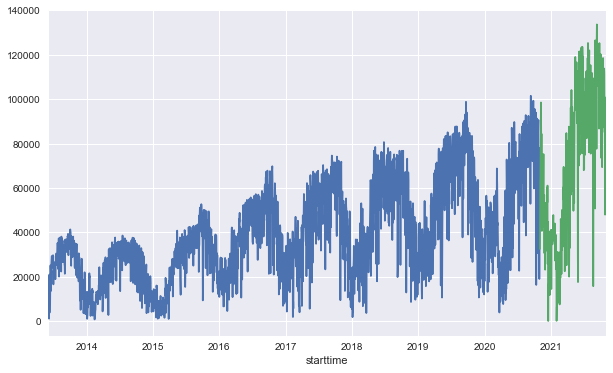

In [9]:
# Define bounds of train / test

daily_ridership['future'] = (daily_ridership.index > '2020-10-31').astype('int')

# Now plot
plt.figure(figsize=(10,6))
daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].plot()
daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot()
plt.show();

In [10]:
# Creating train test splits for our naive models

X_train = daily_ridership.loc[daily_ridership.future == 0, 't'].values.reshape(-1, 1)
X_test = daily_ridership.loc[daily_ridership.future == 1, 't'].values.reshape(-1, 1)

# The train set is the actual value in the series
y_train = daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].values
y_test = daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].values

In [11]:
# Naive baseline prediction, will take the average of the train data

y_preds = daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].mean()

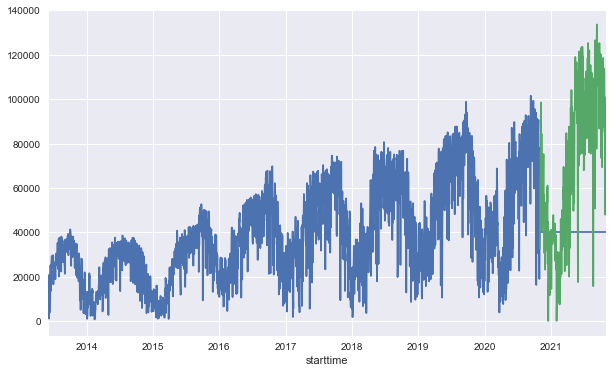

In [12]:
# Plot the baseline prediction

plt.figure(figsize=(10,6))
daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].plot()
daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot()

# Predictions go here
plt.hlines(y=y_preds,
          xmin=daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].index[0],
          xmax=daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].index[-1])


plt.show();

In [13]:
# Show results of first naive model

y_preds = [y_preds] * len(y_test)

results = report_metrics(y_test, y_preds, True)

Explained Variance: 0.0000
MAE: 38,837.6521
RMSE: 47,235.1938
r^2: -0.9238


### Simple linear regression

In [14]:
# Fit the linear model

lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)
y_trend_lr = lr.predict(X_train)

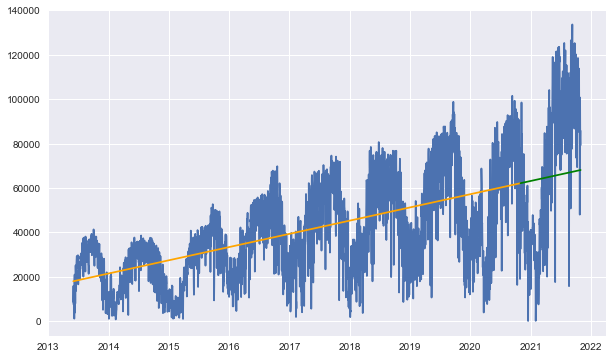

In [15]:
# Plot results

plt.figure(figsize=(10,6))
plt.plot(daily_ridership['ride_count'])
plt.plot(daily_ridership.loc[daily_ridership.future == 0].index, y_trend_lr, color='orange')
plt.plot(daily_ridership.loc[daily_ridership.future == 1].index, y_preds_lr, color='green')
plt.show()

In [16]:
# Evaluate linear regression

results = report_metrics(y_test, y_preds_lr, True)

Explained Variance: 0.0733
MAE: 29,926.7564
RMSE: 33,677.6875
r^2: 0.0221


### Naive Model Takeaways

- These models obviously don't perform paticularly well as expected, but they give us a baseline to compare subsequent models against

## First Arima model

### Modeling EDA

- ACF and PACF plot
- Test correlations of different lags

In [17]:
# Create dataframe to store predictions in

daily_future_df = daily_ridership.loc[daily_ridership.future == 1].copy()

In [18]:
# Add lags for 7 days, one month, and one year to test correlation

daily_ridership['lag7'] = daily_ridership['ride_count'].shift(7)
daily_ridership['lag30'] = daily_ridership['ride_count'].shift(30)
daily_ridership['lag365'] = daily_ridership['ride_count'].shift(365)

# Drop t and future used in Naive model
daily_ridership = daily_ridership.drop(labels=['t'], axis=1)

daily_ridership.corr()

,ride_count,future,lag7,lag30,lag365
ride_count,1.000000,0.415143,0.830055,0.728199,0.701536
future,0.415143,1.000000,0.409670,0.401785,0.223473
lag7,0.830055,0.409670,1.000000,0.748695,0.696030
lag30,0.728199,0.401785,0.748695,1.000000,0.656343
lag365,0.701536,0.223473,0.696030,0.656343,1.000000


Interestingly, the 1 year lag isn't as strongly correlated as I thought. Maybe it's because the mean is constantly increasing. The 7 day lag is reasonably well correlated, suggesting that there is a weekly trend to the data (i.e., more people use the bikes on weekdays to commute).

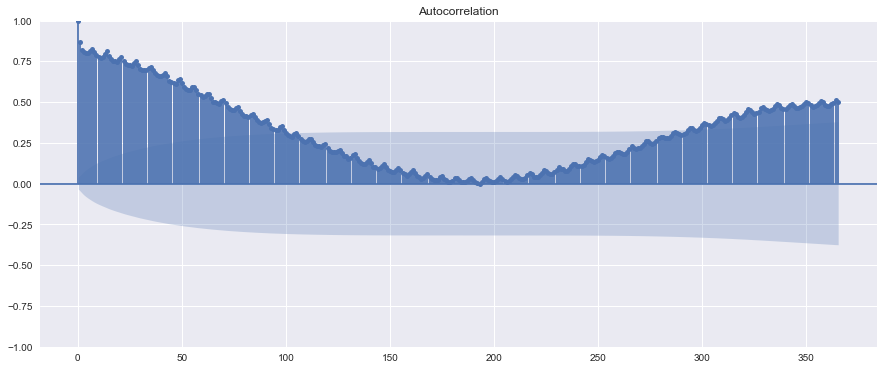

In [19]:
# In the ACF plot, you can clearly see the yearly seasonality in this data
# Less obvious (because of the scale) is the weekly trend as well

fig, ax = plt.subplots(figsize=(15,6))

tsa.plot_acf(daily_ridership['ride_count'], lags=365, ax=ax);

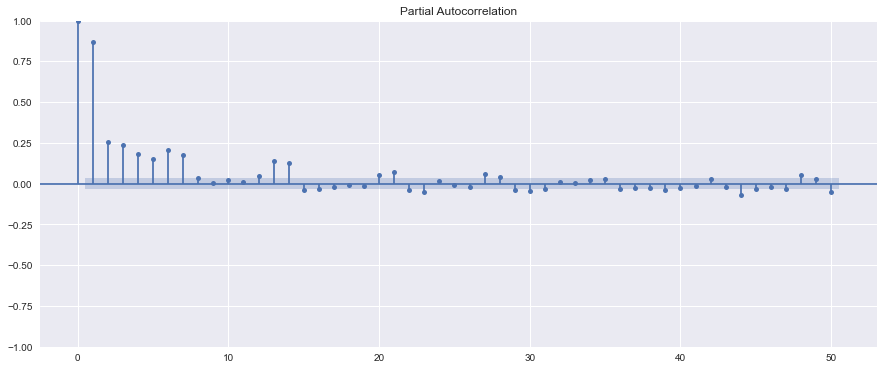

In [20]:
# In the PACF plot, you see more of the weekly trend instead of the seasonal trend

fig, ax = plt.subplots(figsize=(15,6))

tsa.plot_pacf(daily_ridership['ride_count'], method='ywm', lags=50, ax=ax);

In [21]:
# Arima model

# Drop lag columns

daily_ridership.drop(labels=['lag7', 'lag30', 'lag365'], axis=1, inplace=True)

In [22]:
daily_ridership.head()

,ride_count,future
starttime,,
2013-06-01,8722,0
2013-06-02,15971,0
2013-06-03,7598,0
2013-06-04,15782,0
2013-06-05,15690,0


In [23]:
# Fit an ARIMA model
# Choosing 8 for the AR term given the PACF plot previous
# Just using 1 for D and Q until I run a grid search.

arima_order = (8, 1, 1)
arima = ARIMA(daily_ridership.loc[daily_ridership.future == 0]['ride_count'], 
                  order=arima_order)
baseline_arima = arima.fit()

In [24]:
# Create predictions based on the model and store it in a new dataframe

daily_future_df = daily_ridership.loc[daily_ridership.future == 1].copy()
daily_future_df['arima_preds'] = baseline_arima.forecast(steps = len(y_test))

# Print metric summary

results = report_metrics(daily_future_df['ride_count'], daily_future_df['arima_preds'], True)

Explained Variance: -0.0007
MAE: 31,794.5096
RMSE: 35,919.5726
r^2: -0.1125


Haven't improved on the baseline model all that much. Will definitely need to fit a seasonal component.

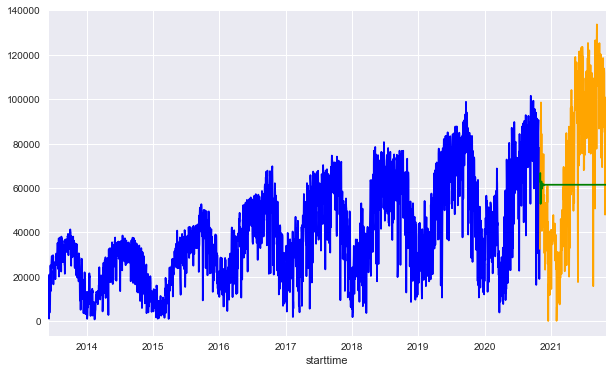

In [25]:
# Plot the first ARIMA model output

fig, ax = plt.subplots(figsize=(10,6))

daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].plot(color='blue', label='actual train', ax=ax)
daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot(color='orange', label='actual test', ax=ax)
daily_future_df['arima_preds'].plot(color='green', label='predicted test', ax=ax);

## First SARIMA model

I clearly need to capture the yearly seasonal component in the data

In [26]:
seas_arima = ARIMA(daily_ridership.loc[daily_ridership.future == 0]['ride_count'], 
                   order = (2, 1, 1), seasonal_order=(0, 0, 0, 365))

baseline_sarima = seas_arima.fit()

In [27]:
# Create predictions based on the model and store it in a new dataframe

daily_future_df['seas_arima_preds'] = baseline_sarima.forecast(steps = len(y_test))

# Print metric summary

results = report_metrics(daily_future_df['ride_count'], daily_future_df['seas_arima_preds'], True)

Explained Variance: -0.0007
MAE: 31,435.0494
RMSE: 35,342.5763
r^2: -0.0770


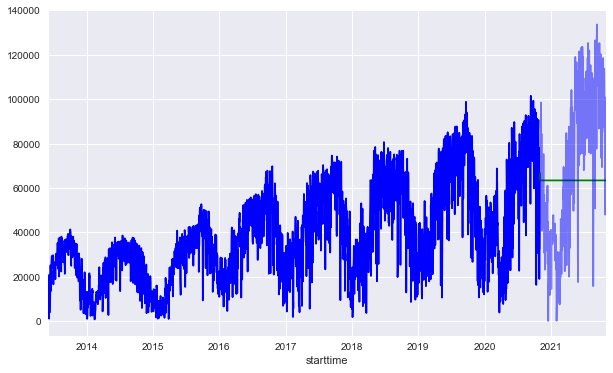

In [28]:
# fig, ax = plt.subplots(figsize=(10,6))

# daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].plot(color='blue', label='actual train', ax=ax)
# daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot(color='orange', label='actual test', ax=ax)
# daily_future_df['seas_arima_preds'].plot(color='green', label='predicted test', ax=ax);

plot_results(daily_ridership, daily_future_df['seas_arima_preds'], False)

This isn't much better. I don't think the 365 day lag is working for the daily data (I've read that it performs poorly if you make the seasonal lag go too far back).

Try removing the yearly seasonal trend and just focus on the weekly trend

In [29]:
# Isolate the seasonal component and divide ridership by this amount

decomposed_ts = decompose(daily_ridership['ride_count'].values, 'multiplicative', m=365)

seasonal = decomposed_ts.seasonal

daily_ridership['seas_removed'] = daily_ridership['ride_count'] / seasonal

daily_ridership['seas_removed_log'] = daily_ridership['seas_removed'].apply(lambda x: np.log(x))

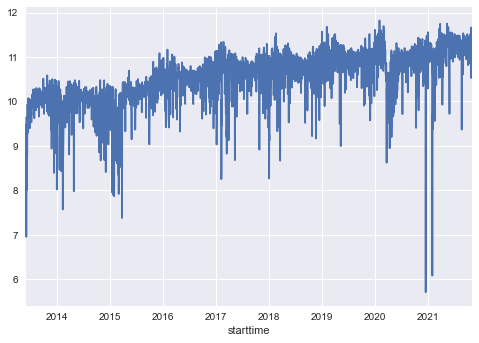

In [30]:
daily_ridership['seas_removed_log'].plot();

In [31]:
seas_removed_arima = ARIMA(daily_ridership.loc[daily_ridership['future'] == 0]['seas_removed_log'], 
                           order = (1, 1, 1), seasonal_order=(1, 0, 0, 7))

seas_arima2 = seas_removed_arima.fit()

In [32]:
# Create a new dataframe to store the results so we have the seasonal variable there

daily_future_df = daily_ridership.loc[daily_ridership.future == 1].copy()

# Add back in the previous results (to compare)
daily_future_df['arima_preds'] = baseline_arima.forecast(steps = len(y_test))
daily_future_df['seas_arima_preds'] = baseline_sarima.forecast(steps = len(y_test))

# Add in Seasonal results
daily_future_df['preds_seas_adj'] = seas_arima2.forecast(steps = len(y_test))

# Print metric summary

results = report_metrics(daily_future_df['seas_removed_log'], daily_future_df['preds_seas_adj'], True)

Explained Variance: -0.0012
MAE: 0.4082
RMSE: 0.5771
r^2: -0.1972


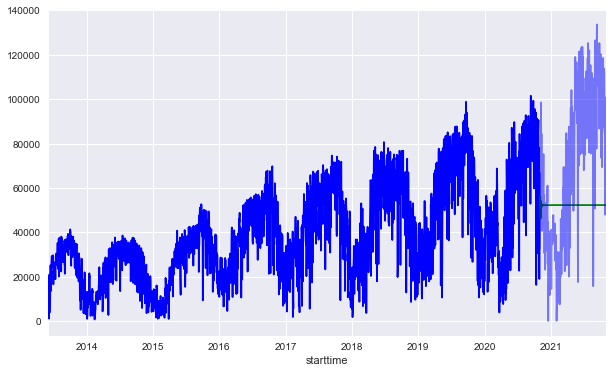

In [33]:
# Plot the results

plot_results(daily_ridership, daily_future_df['preds_seas_adj'], True)

Conclusion: daily data does not seem suitable for making yearly predictions with this data.

## Weekly Ridership

- Forecasting the daily data was challening. There were two seasonal components that we had to deal with: the 7 day ridership cycle, and the 365 day cycle. ARIMA is not well equipped for handling seasonal lags > 100 (link to supporting literature). I tried to de-trend the yearly seasonality and focus only on daily, but I had issues with poor model performance there as well.
- Next step will be to resample the data to be weekly. This will remove the weekly seasonal trend and allow me to focus solely on the yearly relationship.

In [34]:
weekly_ridership = daily_ridership.resample('W-MON').sum().drop('future', axis=1)

In [35]:
# RUn dickey fuller on unadjusted data

dickey_fuller(weekly_ridership['ride_count'], False, True)

# This is actually showing us that it's stationary, but we may want to take a couple additional steps

Data is stationary. P-value of 0.0055


(True, 0.005483242937278968)

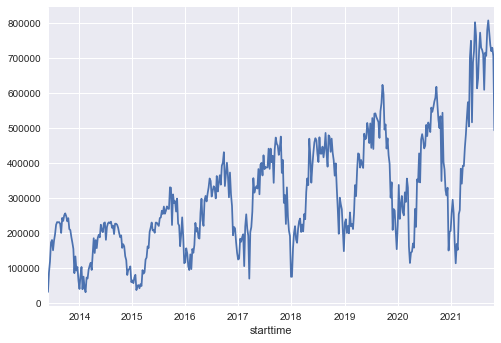

In [36]:
weekly_ridership['ride_count'].plot();

In [37]:
# Create future time stamp

weekly_ridership['future'] = (weekly_ridership.index > '2020-10-31').astype('int')

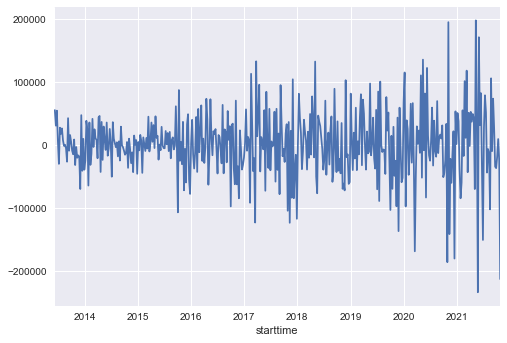

In [38]:
# Plot the 1d diff to visualizing inspect for stationarity

weekly_ridership['1d_diff'] = weekly_ridership['ride_count'].diff()

weekly_ridership['1d_diff'].plot();

# There is increasing variance still, so we may want to log transform the series

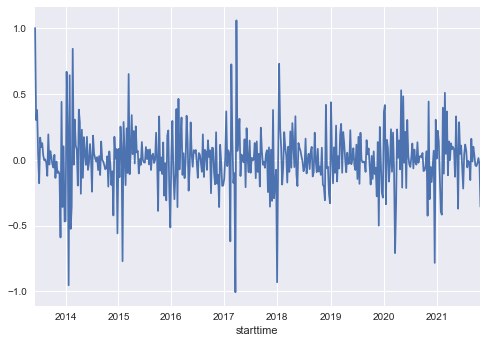

In [39]:
# The log of ride count with the 1d diff looks very stationary, plus we have the obvious 52 week 
# seasonality factor to consider as an input

weekly_ridership['ride_count_log'] = weekly_ridership['ride_count'].apply(lambda x: np.log(x))

weekly_ridership['ride_count_log'].diff().plot();

In [40]:
# Create train test splits

train_weekly = weekly_ridership[weekly_ridership['future'] == 0]['ride_count_log']
test_weekly = weekly_ridership[weekly_ridership['future'] == 1]['ride_count_log']

### Weekly Ridership: Model 1

- Haven't grid searched the SARIMA model just yet, using some placeholder (but sensible) inputs for now
- Training data is the last year

In [41]:
# First seasonal model without grid search, using 52 weeks

seas_mod_weekly = SARIMAX(train_weekly, order=(1, 1, 1), seasonal_order=(1, 1, 0, 52)).fit()

In [42]:
weekly_future_df = weekly_ridership.loc[weekly_ridership.future == 1].copy()

weekly_future_df['baseline_seas'] = seas_mod_weekly.forecast(steps = len(test_weekly))

In [43]:
# Unlogged results

results = report_metrics(np.exp(test_weekly), np.exp(weekly_future_df['baseline_seas']), True)

Explained Variance: 0.7114
MAE: 113,956.4082
RMSE: 132,455.7477
r^2: 0.6247


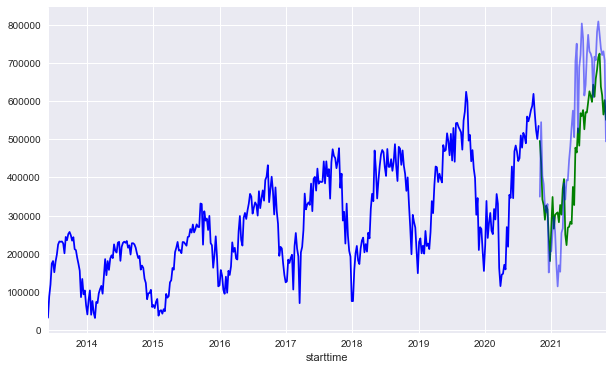

In [44]:
# Plot the results

plot_results(weekly_ridership, weekly_future_df['baseline_seas'], True)

R2 is 0.6, which isn't bad, and explained variance is 60%. Model seems to be struggling a bit with COVID data and is underforecasting 2021. Will try tuning some parameters to see if there's anything I can do to improve this performance.

In [322]:
# Test model out to 2022

seas_mod_weekly2 = SARIMAX(train_weekly, order=(3, 1, 1), seasonal_order=(1, 1, 1, 52)).fit(maxiter=1000)

In [323]:
sarima_preds = pd.DataFrame(seas_mod_weekly2.forecast(steps = len(test_weekly) + 60))
sarima_preds['unlogged'] = sarima_preds['predicted_mean'].apply(lambda x: np.exp(x))

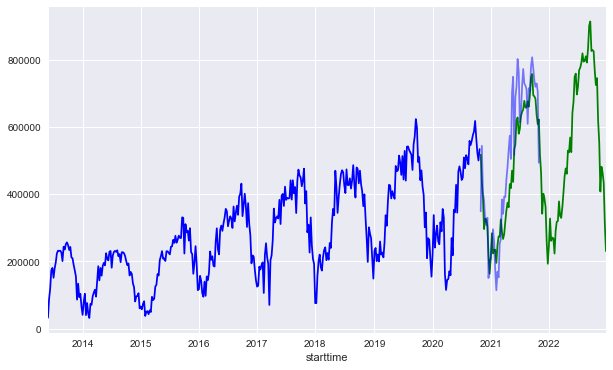

In [324]:
# Plot the results

plot_results(weekly_ridership, sarima_preds['unlogged'], False)

By including a seasonal MA term of 1, the model appears to perform significantly better on 2021 data. Forecasts a sharp increase in 2022, but that might be reasonable given the trends in the data.

### Weekly Ridership: Model 2

- Exclude COVID data when training the model
- Again, this model will use sensible orders / seasonal orders, but will need to be grid searched later.

In [45]:
weekly_ridership2 = weekly_ridership.drop('future', axis=1)

weekly_ridership2['future'] = (weekly_ridership2.index > '2020-03-01').astype('int')

In [46]:
# Make a new train / test split based on new cutoff date

train_weekly2 = weekly_ridership2[weekly_ridership2['future'] == 0]['ride_count_log']
test_weekly2 = weekly_ridership2[weekly_ridership2['future'] == 1]['ride_count_log']

In [47]:
# Train second model (as stated, keeping hyperparemeters constant for now)

seas_mod_weekly2  = SARIMAX(train_weekly2, order=(1, 1, 1), seasonal_order=(1, 1, 0, 52)).fit()

In [48]:
# Store the predictions for the training period

weekly_future_df = weekly_ridership2.loc[weekly_ridership2.future == 1].copy()
weekly_future_df['preds'] = seas_mod_weekly2.forecast(steps = len(test_weekly2))

In [54]:
# Check the results

results2 = report_metrics(np.exp(test_weekly2), np.exp(weekly_future_df['preds']), True)

Explained Variance: 0.7490
MAE: 109,989.0496
RMSE: 138,831.5891
r^2: 0.5116


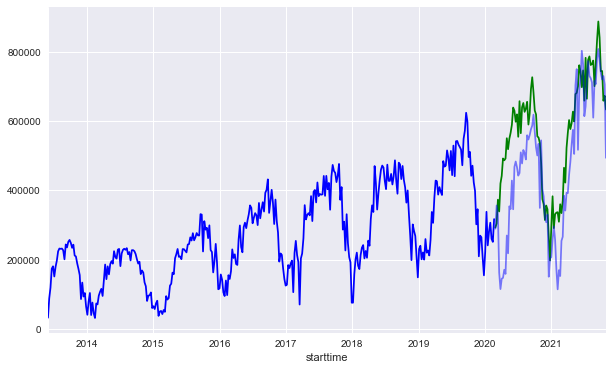

In [49]:
# Plot the results

plot_results(weekly_ridership2, weekly_future_df['preds'], True)

Conclusion: While this model obviously missed the mark on COVID, it seems to perform significantly better on "normalized" data. Explained variance is higher and MAE is lower than on the data that was trained on COVID data. 

I'll do a grid search on this to see if we can't improve the accuracy.

### ARIMA grid search

In [89]:
# Grid search on the training data that stops at 3/1/2021

# arima = pm.auto_arima(train_weekly2, error_action='ignore', trace=True, suppress_warnings=True, maxiter=100,
#                       seasonal=True, m=52)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=14.24 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-3.586, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-46.463, Time=1.75 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-48.985, Time=2.99 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-5.326, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=-28.607, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=8.87 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=-50.703, Time=17.45 sec
 ARIMA(0,1,1)(1,0,2)[52] intercept   : AIC=inf, Time=64.57 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=-12.617, Time=9.46 sec
 ARIMA(1,1,1)(0,0,2)[52] intercept   : AIC=-48.730, Time=24.31 sec
 ARIMA(0,1,2)(0,0,2)[52] intercept   : AIC=-48.742, Time=17.09 sec
 ARIMA(1,1,0)(0,0,2)[52] intercept   : AIC=-42.605, Time=12.88 sec
 ARIMA(1,1,2)(0,0,2)[52] intercept   : AIC=-52.621, Time=42.97 sec
 ARIMA(1,1,2)(0,0,1)[52] intercept   : A

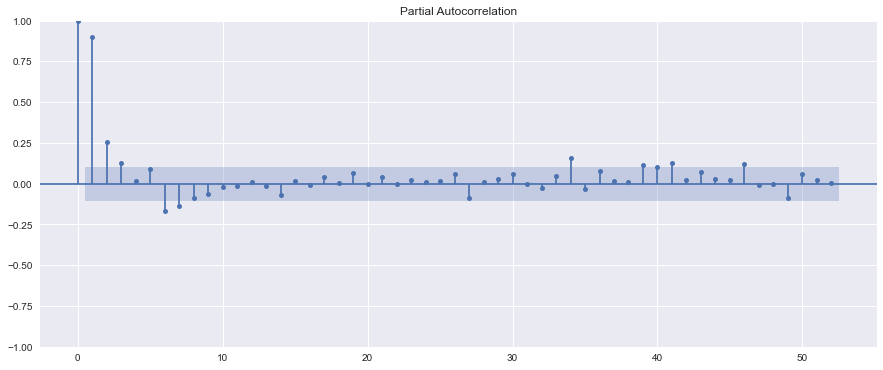

In [165]:
# Run a PACF plot to confirm the AR term

fig, ax = plt.subplots(figsize=(15,6))

tsa.plot_pacf(train_weekly2, method='ywm', lags=52, ax=ax);.

# Seems like using 3 is a reasonable approach. Will not bother plotting ACF plot given seasonality

In [173]:
best_arima = SARIMAX(train_weekly2, order=(3, 1, 1), seasonal_order=(1, 1, 0, 52)).fit()

weekly_future_df['preds_best_arima'] = best_arima.forecast(steps = len(test_weekly2))

results_best_arima = report_metrics(np.exp(test_weekly2), np.exp(weekly_future_df['preds_best_arima']), True)

In [211]:
results_best_arima

[0.7388439368184012, 101995.42559445761, 131188.2487400712, 0.5638999115823984]

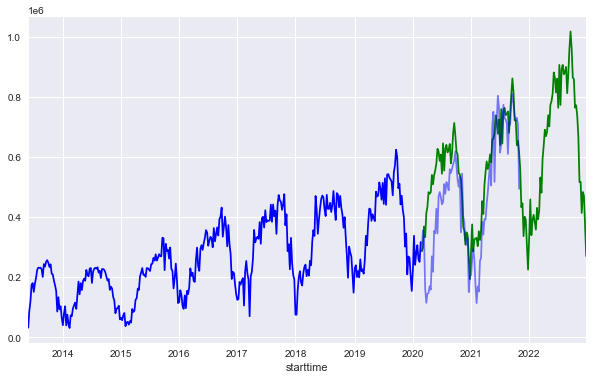

In [328]:
plot_results(weekly_ridership2, best_arima.forecast(steps = len(test_weekly2) + 60), True)

In [209]:
# How many rides does this suggest will happen in 2022?

prediction_2022 = pd.DataFrame(best_arima.forecast(steps = len(test_weekly2) + 60))
prediction_2022['unlogged'] = prediction_2022.apply(lambda x: np.exp(x))

In [210]:
prediction_2022

,predicted_mean,unlogged
2020-03-02,12.565569,286521.414168
2020-03-09,12.604573,297917.814175
2020-03-16,12.818183,368863.947165
2020-03-23,12.717535,333545.806206
2020-03-30,12.929841,412438.127852
...,...,...
2022-11-28,12.933546,413968.768843
2022-12-05,13.088931,483559.995450
2022-12-12,13.061356,470408.121000
2022-12-19,12.808618,365352.657280


In [200]:
prediction_2022[prediction_2022.index > '12/31/2021']['unlogged'].sum()

34658363.46294602